<a href="https://colab.research.google.com/github/Anggarciaar/Proyecto_AnalisisGeoespacial/blob/main/Raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Librerias**

In [2]:
!pip install rioxarray


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.6 MB/s eta 0:00:00


In [3]:
!pip install rioxarray

In [4]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from osgeo import gdal
import os
import geopandas as gpd
import rioxarray as rxr
import fiona
from lxml import etree

import rasterio as rio
from rasterio.plot import show, show_hist
import rasterio.mask
from rasterio.merge import merge
from rasterio.crs import CRS
from rasterio import mask as msk

from shapely.geometry import mapping


## Digital Elevation Models

In [5]:
#Dem de la zona final de estudio
file = rasterio.open('/content/drive/MyDrive/DATA_ProyectoAG/DEM.tif')
dataset = file.read()
print(dataset.shape)

(1, 1119, 1590)


In [6]:
file.crs

CRS.from_epsg(32618)

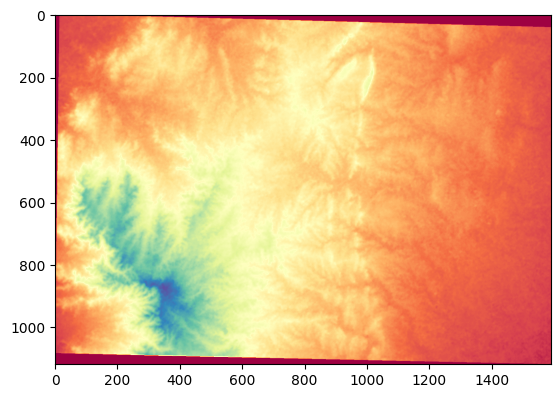

In [7]:
plt.imshow(dataset[0], cmap='Spectral')
plt.show()

In [8]:
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00


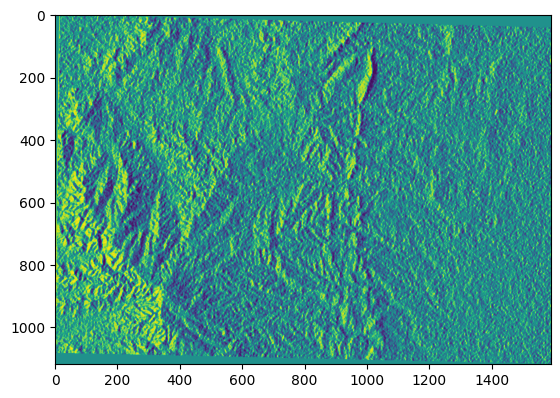

In [9]:
import earthpy.spatial as es
hillshade = es.hillshade(dataset[0], azimuth=270, altitude=1)
plt.imshow(hillshade)

In [10]:
#Unidades geologicas en superficie
df = gpd.read_file('/content/drive/MyDrive/DATA_ProyectoAG/unidades.shp')
df.head(2)

,OBJECTID,SHAPE_Leng,SHAPE_Area,SimboloUC,Descripcio,Edad,UGIntegrad,Comentario,geometry
0,54.0,0.113803,0.000281,n6n7-St,"Intercalaciones de conglomerados, arenitas lít...",Mesiniano-Zancleano,Formación Tubará,2,"POLYGON ((-74.97353 10.66983, -74.97225 10.668..."
1,606.0,1.388248,0.015258,Q-t,Terrazas aluviales,Cuaternario,NaN,4,"MULTIPOLYGON (((-74.95043 10.66920, -74.94946 ..."


In [11]:
df=df.to_crs(epsg=32618)

<Axes: >

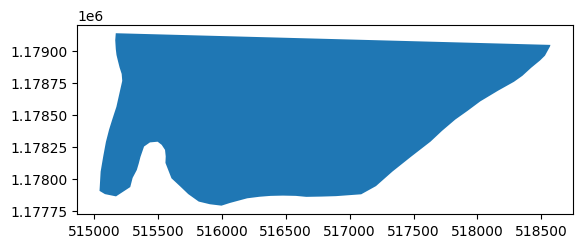

In [12]:
# las unidades estan enumeradas de 1 a 5 segun su factibilidad como zona de exploración donde 5 es la mejor
barrio = df.loc[df['Comentario'] == '5']
barrio.plot()

In [13]:
clipped_array, clipped_transform = msk.mask(file, [mapping(barrio.iloc[0].geometry)], crop=True)

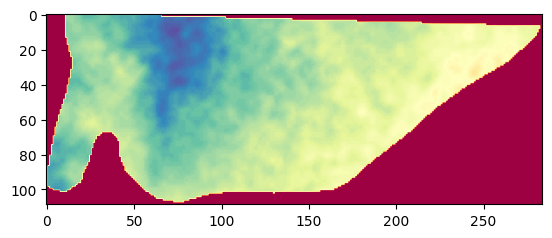

In [14]:
plt.imshow(clipped_array[0], cmap='Spectral')
plt.show()

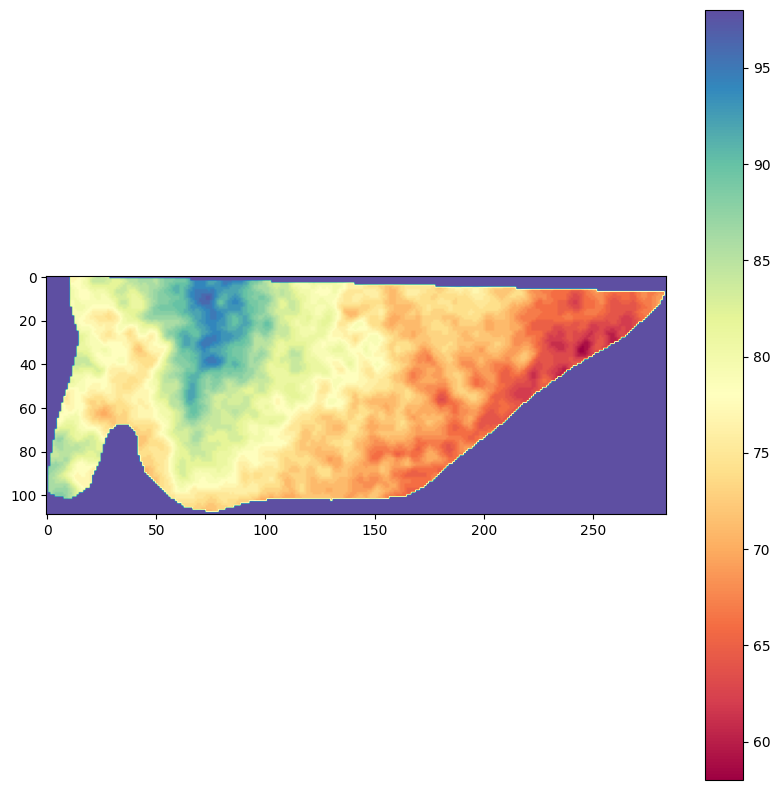

In [15]:
 def clip_raster(gdf, img):
     clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)], crop=True)
     clipped_array, clipped_transform = msk.mask(img, [mapping(gdf.iloc[0].geometry)],
                                                           crop=True, nodata=(np.amax(clipped_array[0]) + 1))
     clipped_array[0] = clipped_array[0] + abs(np.amin(clipped_array))
     value_range = np.amax(clipped_array) + abs(np.amin(clipped_array))
     return clipped_array, value_range

barrio_topography, value_range = clip_raster(barrio, file)

plt.figure(figsize=(10,10))
c = plt.imshow(barrio_topography[0], cmap='Spectral')
plt.colorbar(c)
plt.show()

## Algebra de mapas

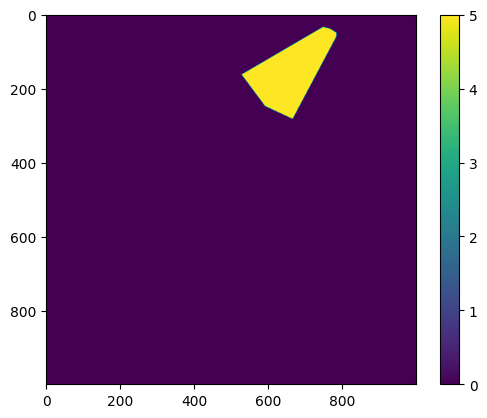

In [30]:
im = rasterio.open("/content/drive/MyDrive/DATA_ProyectoAG/DEM/emisiones.tif")
im_array = im.read(1).astype(np.float32)  # Lee la primera banda como una matriz de tipo float32
plt.imshow(im_array)
plt.colorbar()


In [6]:
#b2:Densidad de datos, b3:Amenaza Sismica, b4:Emisiones de CO2
b4_ = gdal.Open("/content/drive/MyDrive/DATA_ProyectoAG/DEM/emisiones.tif")
b4 = b4_.ReadAsArray()
b3_ = gdal.Open("/content/drive/MyDrive/DATA_ProyectoAG/DEM/Sismicidad.tif")
b3 = b3_.ReadAsArray()
b2_ = gdal.Open("/content/drive/MyDrive/DATA_ProyectoAG/DEM/datos.tif")
b2 = b2_.ReadAsArray()
b1_ = gdal.Open("/content/drive/MyDrive/DATA_ProyectoAG/DEM/Volcanes.tif")
b1 = b1_.ReadAsArray()

In [21]:
b3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

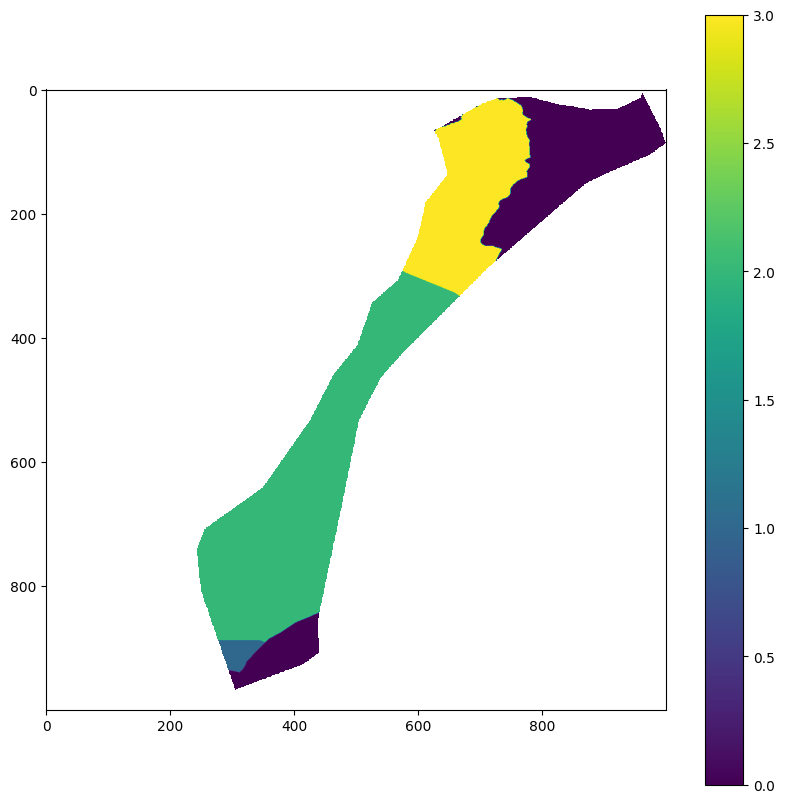

In [22]:
b1_nan=np.where(b1==0,np.nan,b3)
plt.figure(figsize=(10,10))
plt.imshow(b1_nan)
plt.colorbar()

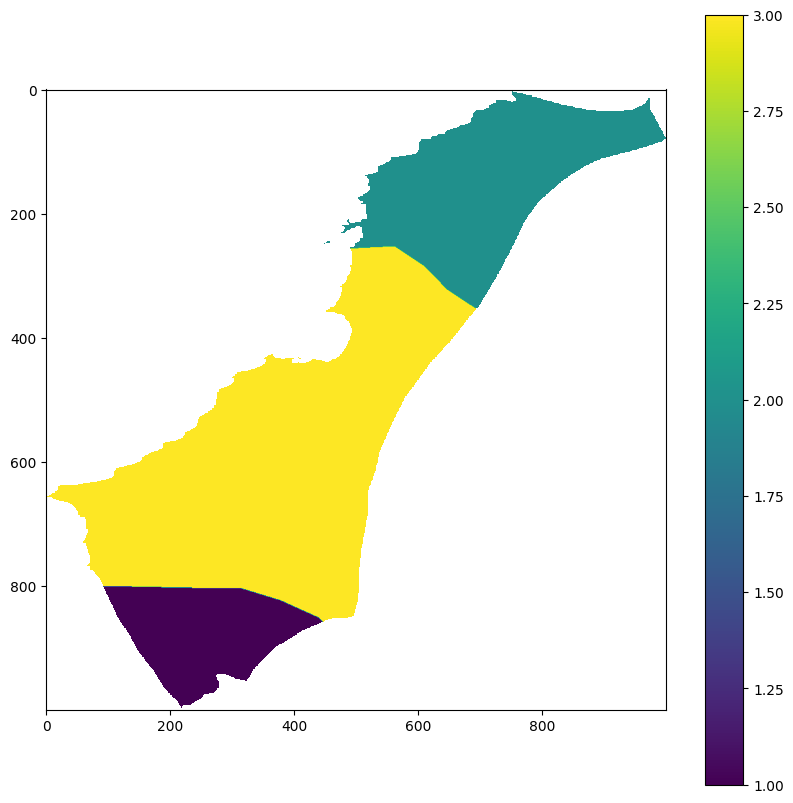

In [8]:
b3_nan=np.where(b3==0,np.nan,b3)
plt.figure(figsize=(10,10))
plt.imshow(b3_nan)
plt.colorbar()

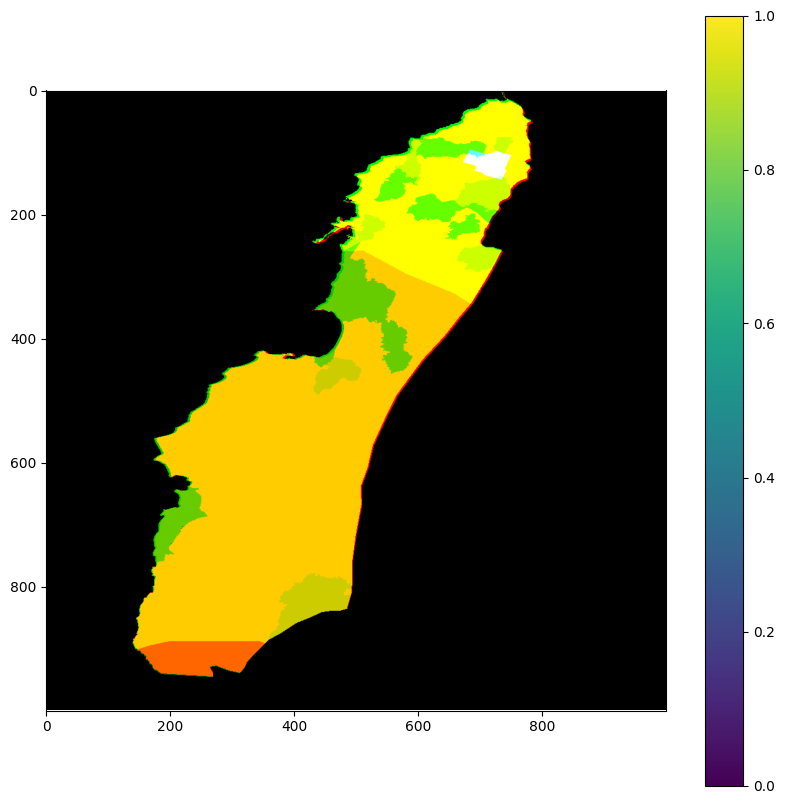

In [23]:
rgb = np.stack([b4,b3, b2], axis=-1)
rgb = rgb/rgb.max() * 2.0
plt.figure(figsize=(10,10))
plt.imshow(rgb)
plt.colorbar()

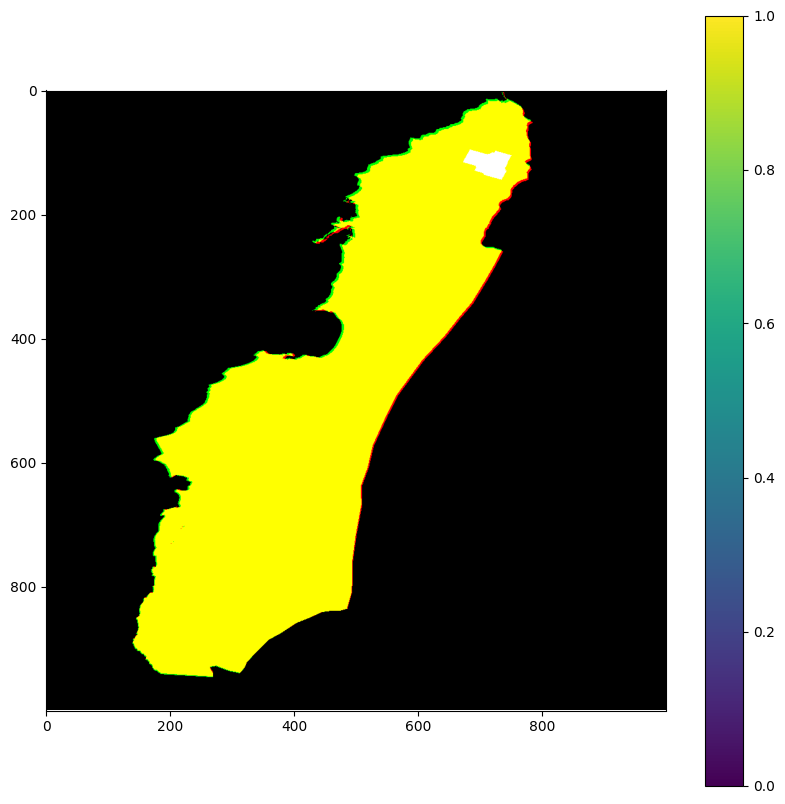

In [24]:
FalseColor = np.stack([b4, b3, b2], axis=-1)
FalseColor = FalseColor/rgb.max() * 2.0
plt.figure(figsize=(10,10))
plt.imshow(FalseColor)
plt.colorbar()

### Index

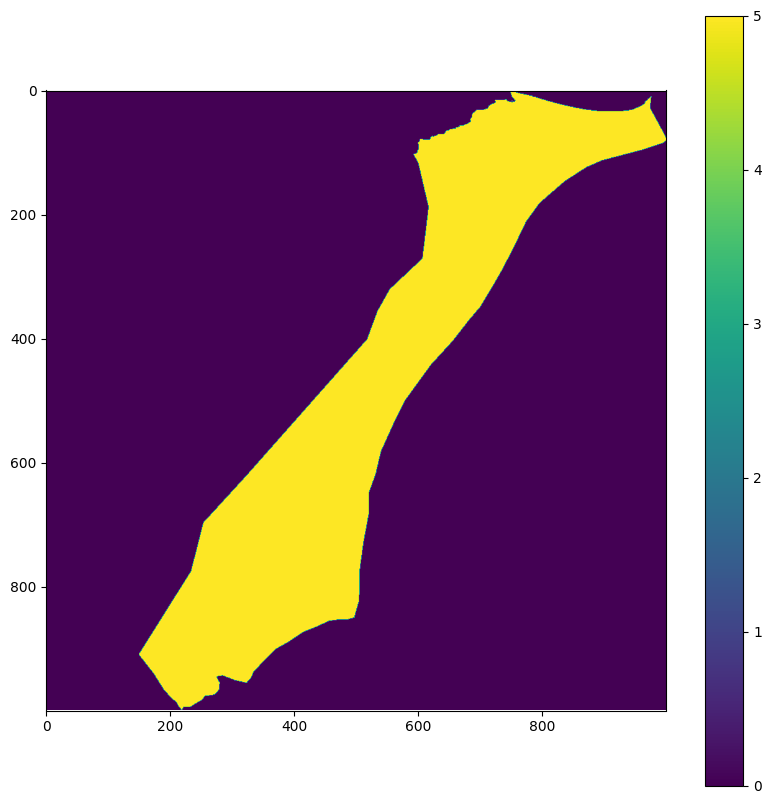

In [22]:
NDVI = (b1)
plt.figure(figsize=(10,10))
plt.imshow(NDVI)
plt.colorbar()

plt.savefig('/content/drive/MyDrive/DATA_ProyectoAG/Datos creados/lodo.png')

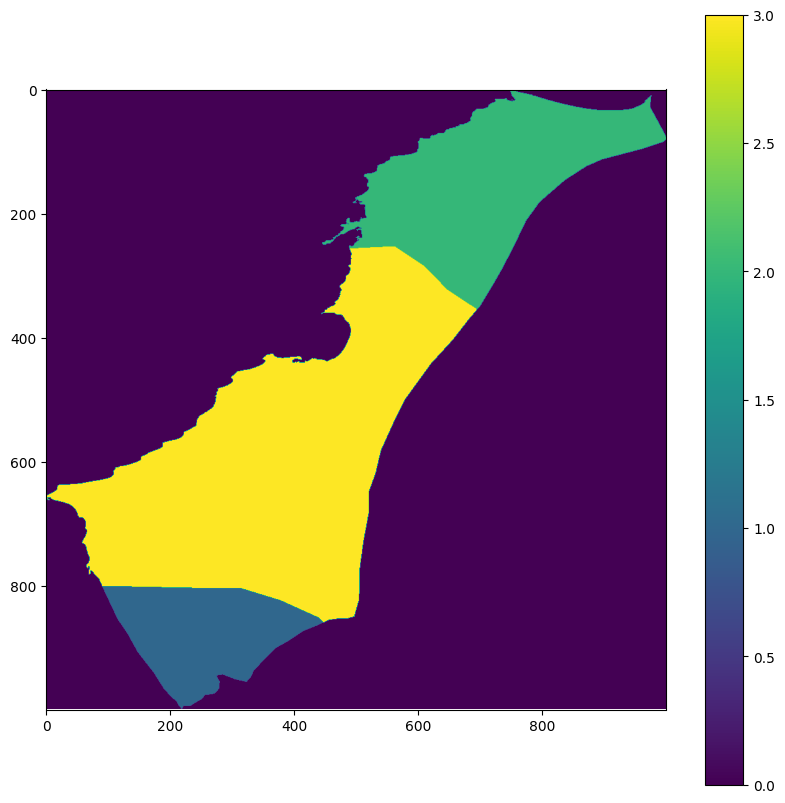

In [21]:
NDVI = (b3)
plt.figure(figsize=(10,10))
plt.imshow(NDVI)
plt.colorbar()

plt.savefig('/content/drive/MyDrive/DATA_ProyectoAG/Datos creados/Sismicidad.png')

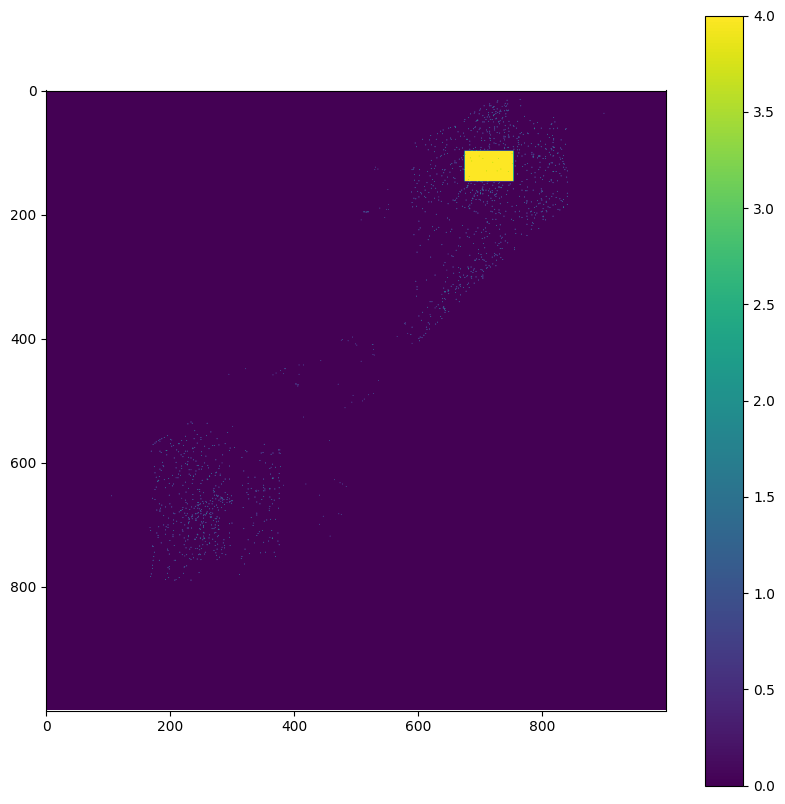

In [20]:
NDVI = (b2)
plt.figure(figsize=(10,10))
plt.imshow(NDVI)
plt.colorbar()

plt.savefig('/content/drive/MyDrive/DATA_ProyectoAG/Datos creados/datos_pozos_2d_3d.png')

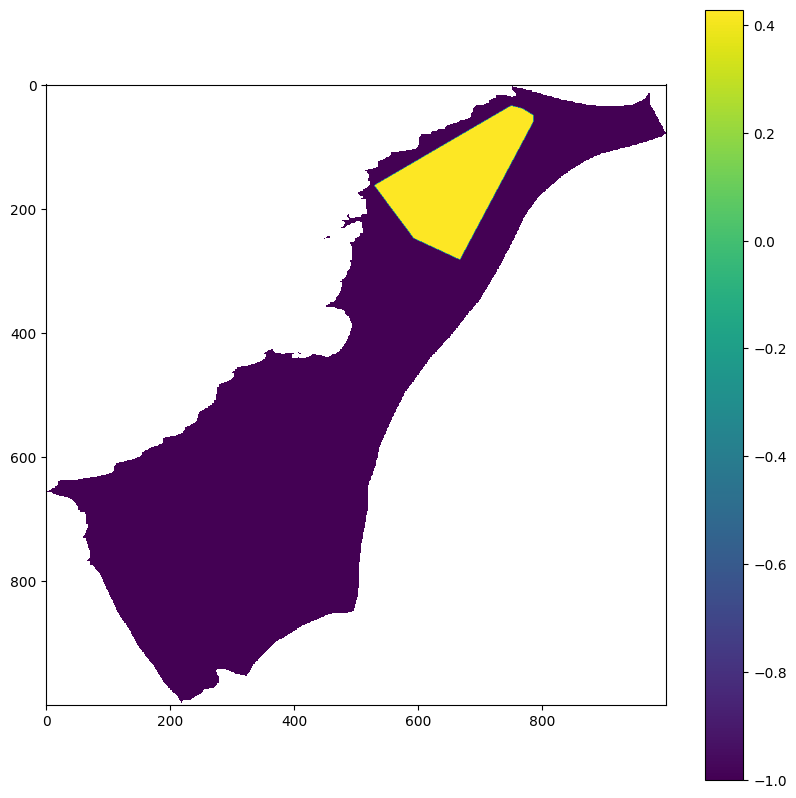

In [10]:
NDVI = (b4-b3)/(b4+b3)
plt.figure(figsize=(10,10))
plt.imshow(NDVI)
plt.colorbar()

plt.savefig('/content/drive/MyDrive/DATA_ProyectoAG/Datos creados/Zonaentremaymisiones.png')

In [26]:
!pip install contextily
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 7.2 MB/s eta 0:00:00


In [27]:
import contextily as ctx
import matplotlib.pyplot as plt

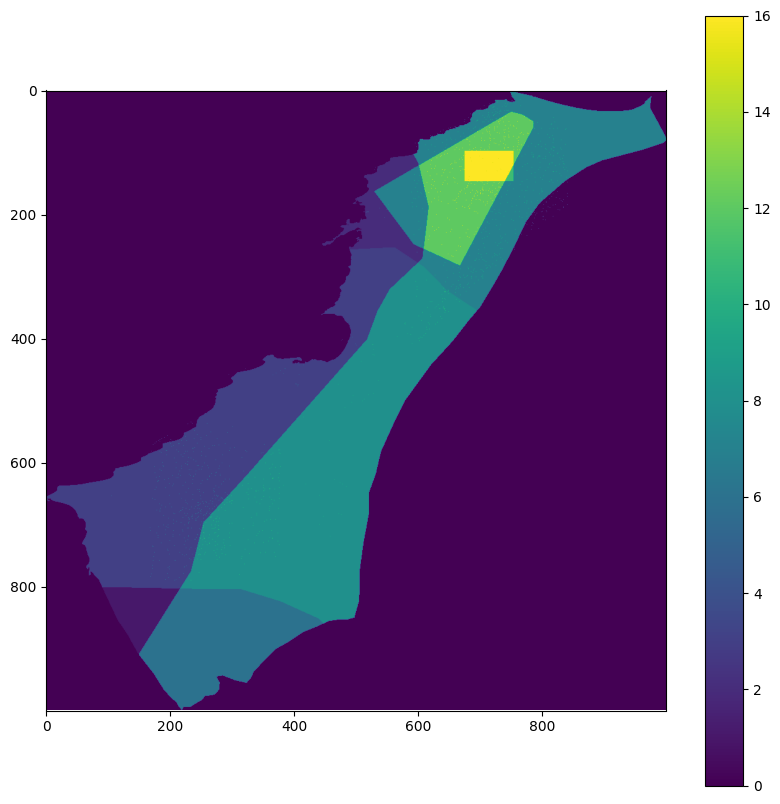

In [7]:

NDVI = (b4+b3+b2+b1)
plt.figure(figsize=(10,10))
plt.imshow(NDVI)
plt.colorbar()


plt.savefig('/content/drive/MyDrive/DATA_ProyectoAG/Datos creados/mejorzona.png')


### Rasterio

In [29]:
Dem= rasterio.open('/content/drive/MyDrive/DATA_ProyectoAG/DEM.tif')

In [30]:
 nir = Dem.read()

In [31]:
# Or read the entire dataset into a single 3D array:
data = Dem.read()

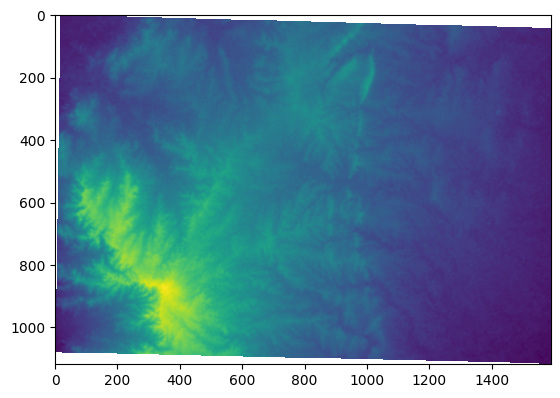

<Axes: >

In [32]:
nir= np.where(nir==0,np.nan, nir)
show(nir)

In [33]:
B1=Dem.read(1)

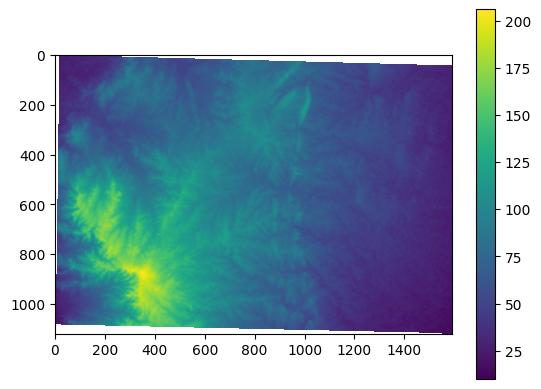

In [34]:
b1 = np.where(B1==0,np.nan, B1)
plt.imshow(b1)
plt.colorbar()

In [35]:
vector=B1.ravel()
vector_rec=vector[vector!=0]
vector_rec.mean()

74.87721616986715

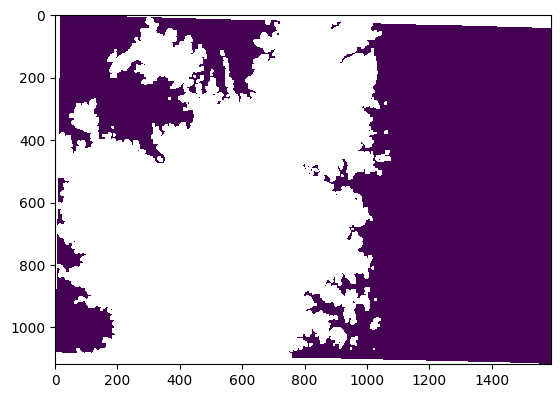

<Axes: >

In [36]:
check = np.logical_and ( B1 > 0, B1 < 75 )
B1_rango=np.where(check,1,np.nan)
show(B1_rango)

In [37]:
show((satdat, 1 ), cmap='Blues')

NameError: ignored

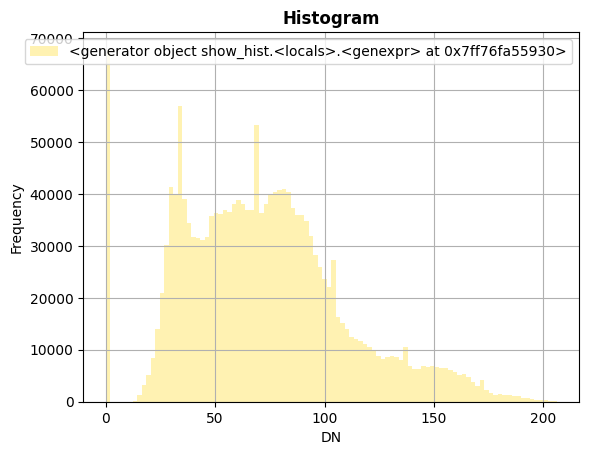

In [41]:
show_hist(B1, bins=100, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

In [42]:
from rasterio.plot import show, adjust_band
imgdata = np.array([adjust_band(satdat.read(i)) for i in range(1, 2)])
show(imgdata*1.5)  # factor to increase brightness

NameError: ignored

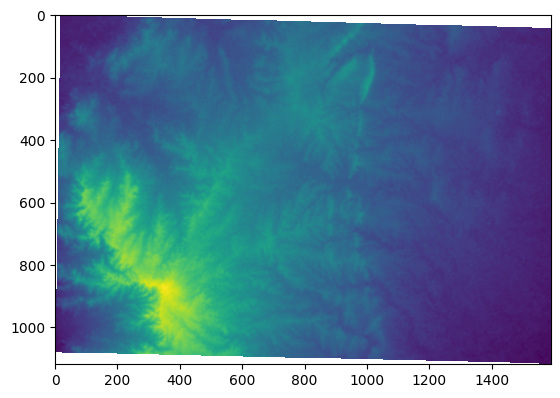

<Axes: >

In [43]:
vector=B1.ravel()
vector_rec=vector[vector!=0]
vector_rec.mean()

B1_nan=np.where(B1==0,np.nan,B1)
show(B1_nan)

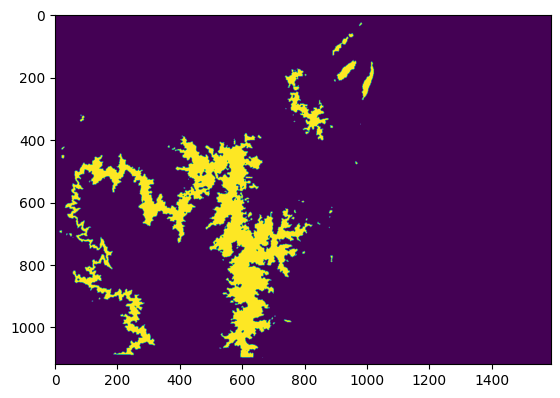

In [44]:
check = np.logical_and ( B1_nan > 100, B1_nan < 120 )
B1_rango=np.where(check,1,0)
show(B1_rango);